# Rannsókn á sjóslysum á Íslandi
## 1950 - 2018

**_Benedikt Óskarsson  
SC-T-498-GAGR  
Háskólinn í Reykjavík_ **  


## Formáli

Í aldanna rás hafa við Íslandsstrendur allt frá landnámi farist óteljandi sjómenn í sjóslysum í kringum landið. Hverju slysi fylgir sorgarsaga en um leið er margt sem er áhugavert að skoða í þessu samhengi og jákvætt að sjá hversu mikið sjóslysum hefur fækkað og má nefna að árið 2014 var líklega fyrsta ár frá landnámi þar sem enginn fórst í sjóslysi við landið.  
  
Í þessari skýrslu verður skoðað gagnasett sem inniheldur upplýsingar um öll banaslys sem hafa orðið við landið frá árinu 1950. Gagnasettið er fengið frá Hilmari Snorrasyni skólastjóra Slysavarnarskóla sjómanna og Rannsóknarnefnd sjóslysa.  
  
Í föðurætt minni hafa í nánast allir karlmenn starfað við sjómennsku og amma mín, Kristrún Óskarsdóttir, fórst í sjóslysi árið 1983 með skipinu _Haferni SH_. Því fannst mér áhugavert að velja þetta efni og gagnasett.

![Djúpið](http://www.icelandicfilms.info/media/1462/large/Djupid-3-a-kili_B.jpg)

### Gagnasett sótt og gögn hreinsuð

In [1]:
# import relevant python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import requests as r
import urllib
import graphviz
import collections
from bs4 import BeautifulSoup
from time import strptime
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn import tree
from sklearn.metrics import accuracy_score
%matplotlib inline

Gagnasetti er hér hlaðið inn og má sjá hvernig það lítur út í upprunalegri mynd.

In [2]:
df = pd.read_csv('./csv\'s/casualtiesAtSea.csv', sep=';')
df.head()

,Ár,Nafn,Aldur,Skip,Orsök,Flokkun atviks,Tegund,Undirflokkur,Brl,Lgd,...,Efni,Sskr.,Ath,Meðalaldur,Ár.1,Mán,Dagur,Flokkur,Aldur skips,Lengdarflokkur
0,07/01/1950,Þórður Bernharðsson,16.0,Helgi VE,Fórust með skipum,Fórst með skipi,Fiskiskip,NaN,NaN,"25,78",...,Eik,115,Farþegi,NaN,1950,1.0,7.0,NaN,11,yfir 24
1,07/01/1950,Óskar Magnússon,22.0,Helgi VE,Fórust með skipum,Fórst með skipi,Fiskiskip,NaN,NaN,"25,78",...,Eik,115,NaN,NaN,1950,1.0,7.0,NaN,11,yfir 24
2,07/01/1950,Hálfdán Brynjólfsson,23.0,Helgi VE,Fórust með skipum,Fórst með skipi,Fiskiskip,NaN,NaN,"25,78",...,Eik,115,NaN,NaN,1950,1.0,7.0,NaN,11,yfir 24
3,07/01/1950,Sigurður Ágúst Brynjólfsson,26.0,Helgi VE,Fórust með skipum,Fórst með skipi,Fiskiskip,NaN,NaN,"25,78",...,Eik,115,NaN,NaN,1950,1.0,7.0,NaN,11,yfir 24
4,07/01/1950,Gústaf Adolf Runólfsson,27.0,Helgi VE,Fórust með skipum,Fórst með skipi,Fiskiskip,NaN,NaN,"25,78",...,Eik,115,NaN,NaN,1950,1.0,7.0,NaN,11,yfir 24


Hér að neðan er byrjað á að losa gagnsettið við óþarfa dálka sem innhalda engar upplýsingar eða upplýsingar sem má finna í öðrum dálkum. Einnig losum við gagnasettið við dálka sem innihalda engar upplýsingar í minna en 30% tilvika af því áætla má að ekki sé nægar marktækar upplýsingar að fá.  

Einnig má sjá þegar gögnin eru skoðuð nánar að dálkarnir _orsök_ og _flokkun atviks_ eru dálkar sem innhalda í flestum tilfellum sömu eða mjög svipaðar upplýsingar. Þannig við losum okkur við dálkinn orsök.

In [3]:
# We have the same values in the first column
df = df.drop(['Ár.1', 'Mán','Dagur'], axis=1)
    
# We have the this information in other columns
df = df.drop(['Aldur skips', 'Lengdarflokkur', 'Orsök', 'Sskr.'], axis=1)
df = df.rename(columns={'Ár':'Dagsetning'})

total_entries = df.index.size

for column in df:
    null_ratio = df[column].isnull().sum() / total_entries
    if null_ratio > 0.7:
        df = df.drop([column], axis=1)
        
df.tail()

,Dagsetning,Nafn,Aldur,Skip,Flokkun atviks,Tegund,Undirflokkur,Brl,Lgd,Smíðaár,Efni
904,21/03/2012,Jón Haukur Njálsson,24.0,Sigurbjörg ÓF,Vinnuslys,Fiskiskip,Skuttogari,516,"54,94",1979,Stál
905,25/07/2013,Gunnar Hersir Benediktsson,22.0,Skinney SF,Féll fyrir borð,Fiskiskip,Skuttogari,242,"28,89",2009,Stál
906,07/07/2015,Magnús Kristján Björnsson,61.0,Jón Hákon BA,Fórst með skipi,Fiskiskip,Dragnót,26,"15,64",1988,Stál
907,27/04/2016,Ólafur Jóhannes Frirðiksson,54.0,Guðmundur Jónsson ST,Féll fyrir borð,Fiskiskip,Strandveiðar,NaN,NaN,NaN,NaN
908,11/05/2016,Eðvarð Arnar Kristinsson,34.0,NaN,Féll fyrir borð,Fiskiskip,Strandveiðar,NaN,NaN,NaN,NaN


Hérna er síðan farið í gegnum þær dagsetningar sem er að finna í gögnunum og þeim komið á rétt og sama formið til þess að auðvelda vinnslu með þær. Einnig er ákveðnum dálkum komið yfir á annað form sem hentar betur.

Einnig vantar upplýsingar um aldur fyrir einn sjómann í gögnunum og þá ætlum við að spá fyrir um aldur hans, það gerum við einfaldlega með því að skoða hver algengasti dánaraldurinn er í gögnunum og nota þann aldur til að fylla í þann aldur sem vantar. 

In [4]:
# This loop is used to convert dates that have the format 01-Jan-01 to 01/01/2001
for i, date in enumerate(df.Dagsetning):
    if '-' in date:
        converted_date = ''
        split_dates = date.split('-')
        converted_date = split_dates[0] + '/'
        month = strptime(split_dates[1], '%b').tm_mon
        converted_date += '0' + str(month) if month < 10 else str(month)
        converted_date += '/20' + split_dates[2] if int(split_dates[2]) < 50 else '/19' + split_dates[2]
        df.loc[df.index[i], 'Dagsetning'] = converted_date

# To datetime format
df.Dagsetning = pd.to_datetime(df.Dagsetning, format='%d/%m/%Y')

# Finding the most common age to fill in for the only missing nan value
age_list = df.Aldur.tolist()
most_common = max(set(age_list), key=age_list.count)
df.Aldur = df.Aldur.fillna(most_common)

df.Aldur = df.Aldur.astype(int)
df.Lgd = pd.to_numeric(df.Lgd.str.replace(',','.'), errors='coerce').astype(float)
df.Brl = pd.to_numeric(df.Brl.str.replace(',','.'), errors='coerce').astype(float)
df.head()

,Dagsetning,Nafn,Aldur,Skip,Flokkun atviks,Tegund,Undirflokkur,Brl,Lgd,Smíðaár,Efni
0,1950-01-07,Þórður Bernharðsson,16,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik
1,1950-01-07,Óskar Magnússon,22,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik
2,1950-01-07,Hálfdán Brynjólfsson,23,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik
3,1950-01-07,Sigurður Ágúst Brynjólfsson,26,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik
4,1950-01-07,Gústaf Adolf Runólfsson,27,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik


Eftir að dagsetningu hefur verið komið á rétt form þá er ágætis hugmynd að nota dagsetninguna sem vísitölu _(e. index)_ fyrir gögnin.

In [5]:
df = df.set_index('Dagsetning')
df.head()

,Nafn,Aldur,Skip,Flokkun atviks,Tegund,Undirflokkur,Brl,Lgd,Smíðaár,Efni
Dagsetning,,,,,,,,,,
1950-01-07,Þórður Bernharðsson,16,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik
1950-01-07,Óskar Magnússon,22,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik
1950-01-07,Hálfdán Brynjólfsson,23,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik
1950-01-07,Sigurður Ágúst Brynjólfsson,26,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik
1950-01-07,Gústaf Adolf Runólfsson,27,Helgi VE,Fórst með skipi,Fiskiskip,NaN,NaN,25.78,1939,Eik


## Skoðun og greining gagna

### Hversu margir sjómenn hafa látist við Ísland frá 1950?

Ef gögnin eru talin kemur í ljós að 909 sjómenn hafa farist frá 1950 sem er mjög stór tala fyrir litla þjóð eins og Ísland. Ef við skoðum hinsvegar fjölda látinna á ársgrundvelli má sjá augljósa og mikla fækkun á banaslysum sem er mjög jákvætt fyrir sjómannsstéttina og íslenska þjóð. 

Hér að neðan má sjá fjölda látinna ár frá ári og einnig yfir 10 ára tímabil í einu.

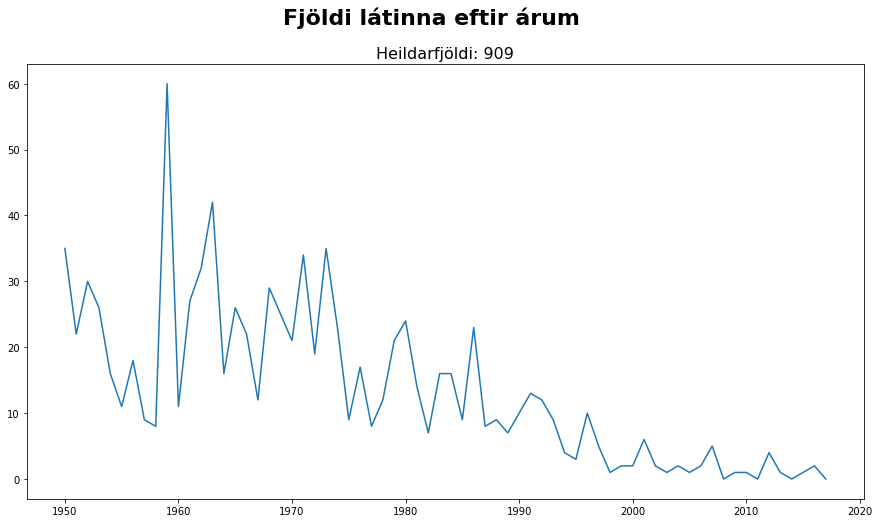

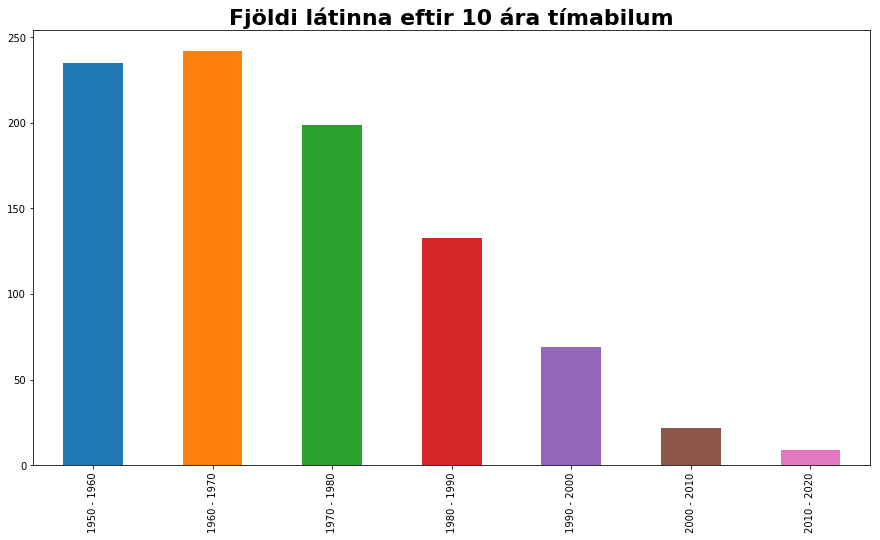

In [6]:
deathByYearGroups = df.groupby(df.index.year)

deathByYearX = []
deathByYearY = []

# This for loop is to make sure we also plot the few years where no one did die
for i in range(1950, 2018):
    deathByYearX.append(i)
    if i in deathByYearGroups['Nafn'].groups:
        deathByYearY.append(len(deathByYearGroups['Nafn'].groups[i]))
    else:
        deathByYearY.append(0)
        
# Plotting the graph
plt.rc('figure', figsize=(15, 8))
plt.plot(deathByYearX, deathByYearY)
plt.title('Heildarfjöldi: ' + str(len(df.index)), fontdict={'size': 16})
plt.suptitle('Fjöldi látinna eftir árum', fontsize=22, fontweight='bold')
plt.show()


# This code is used to count how many have died on a ten year period
deathByTenYear = []
tempCounter = 0
tempVar = 0

for i, death in enumerate(deathByYearY):
    if tempCounter is 10 or i is len(deathByYearY)-1:
        deathByTenYear.append(tempVar)
        tempCounter = 0
        tempVar = 0
    tempVar+= death
    tempCounter += 1

yearLables = [] 
year = 1950

for years in deathByTenYear:
    yearLables.append(str(year) + ' - ' + str(year + 10))
    year += 10
yearLables

yearSeries = pd.Series(deathByTenYear, index=yearLables)

yearSeriesPlot = yearSeries.plot(kind='bar')
yearSeriesPlot = yearSeriesPlot.set_title('Fjöldi látinna eftir 10 ára tímabilum', fontdict={'size': 22, 'weight':'bold'})

### Með hvaða hætti látast sjómenn?

Ef við skoðum nánar með hvaða hætti sjómenn látast þá kemur það kannski lítið á óvart að flestir látast með skipum sem farast. En það sem er merkilegra að skoða er hversu margir hafa látist með öðrum hætti, til að mynda hafa um 200 manns fallið fyrir borð, í kringum 120 drukknað í höfn og um 70 látist í vinnuslysum. Þessar tölur verða að teljast sem ansi hátt hlutfall og segir okkur vel hvað sjómannsstarfið er og sérstaklega hefur verið hættulegt fyrir örfáum áratugum síðan.


Text(0.5,1,'Flokkun atviks')

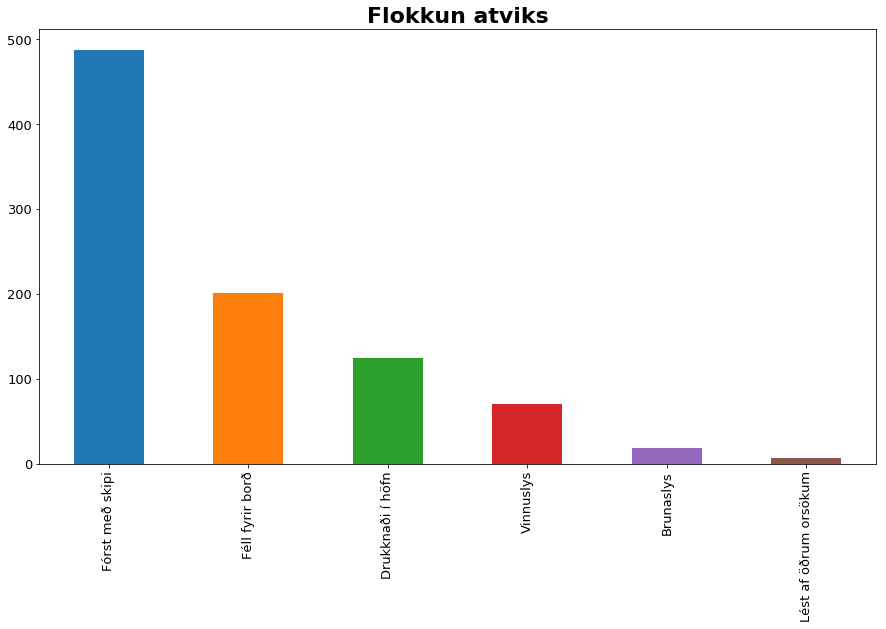

In [7]:
category_plot = df['Flokkun atviks'].value_counts().plot(kind='bar',figsize=(15, 8), fontsize=13)
category_plot = category_plot.set_title('Flokkun atviks', fontdict={'size': 22, 'weight':'bold'})
category_plot

### Hlutfall milli karla og kvenna

Í gögnunum er ekki að finna beinar upplýsingar um kyn þeirra sem hafa látist en við getum notað ýmsar aðferðir til að flokka gögnin eftir kyni. Þegar um íslensk nöfn er að ræða er einfaldast að athuga hvort nöfnin enda á _'son'_ eða _'dóttir'_ en í sumum tilfellum dugar það ekki, þess vegna sækjum við upplýsingar um öll karlmannsnöfn og prófum að bera saman við það. Enn standa þó örfá tilfelli fyrir utan og þá er oftast um útlensk nöfn að ræða, sem eru síðan handflokkuð í þessu verkefni og þegar nöfnin eru skoðuð má sjá að þau virðast öll vera karlmannsnöfn.

Óflokkuð nöfn:  ['Sofus Morten Dalberg', 'Leif Mohr', 'Daniel Tausen', 'Kaz Imierz Walerian Gron', 'Tomas Jespersen', 'Ulrick Hansen', 'Arnfinn Jörensen', 'Holberg Bernhardsen', 'Niels Jul Haraldsen', 'Jaib Abdelouahd - Marokkóbúi']


Text(0.5,1,'Hlutföll kynja')

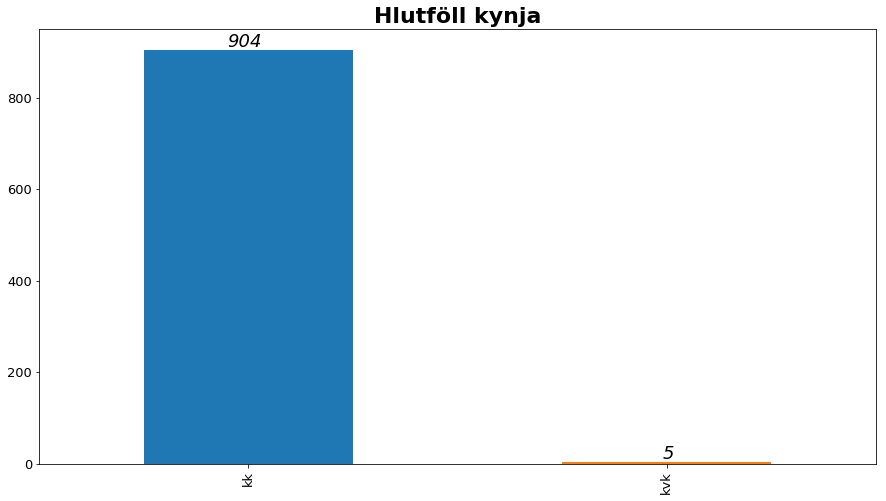

In [8]:
# We use BeautifulSoup to get all the icelandic male names to sort out edge cases were names don't end wit 'son'
allMaleNames = []
request = r.get('https://www.island.is/mannanofn/leit-ad-nafni/?Stafrof=&Nafn=&Drengir=on&Samthykkt=yes')
soup = BeautifulSoup(request.content, 'html.parser')
headDiv = soup.findAll('div', {'class': 'nametype'})
lists = headDiv[0].findAll('ul', {'class': 'dir'})

for singleList in lists:
    items = singleList.findAll('li')
    for item in items:
        # On the site we have edge cases were li includes the string 'úrsk.' that we want to ignore
        if 'úrsk.' not in item.text:
            allMaleNames.append(item.text.strip())
   

# Counting male and female names
maleCount = 0
femaleCount = 0
oddCases = []
sexList = []
        
for name in df['Nafn']:
    if name.endswith('dóttir'):
        femaleCount += 1
        sexList.append('kvk')
    elif name.endswith('son'):
        maleCount += 1
        sexList.append('kk')
    else:
        # Split names into parts to 
        nameParts = name.split()
        for i, part in enumerate(nameParts):
            if part in allMaleNames:
                maleCount += 1
                sexList.append('kk')
                break
            elif i is len(nameParts)-1:
                oddCases.append(name)
                sexList.append('NA')
                
print('Óflokkuð nöfn: ', oddCases)

# After looking at the odd names we assume they are male
sexList = ['kk' if x == 'NA' else x for x in sexList]
df['Kyn'] = sexList

sex_plot = df['Kyn'].value_counts().plot(kind='bar',figsize=(15, 8), fontsize=13)


p1 = sex_plot.patches[0]
p2 = sex_plot.patches[1]
sex_plot.annotate(str(p1.get_height()), (p1.get_x() + 0.2, p1.get_height() + 7), fontsize=18, style='italic')
sex_plot.annotate(str(p2.get_height()), (p2.get_x() + 0.24, p2.get_height() + 7), fontsize=18, style='italic')
sex_plot = sex_plot.set_title('Hlutföll kynja', fontdict={'size': 22, 'weight':'bold'})

sex_plot

### Hver var aldur sjómanna sem hafa farist?

Þegar skoðað er hversu gamlir sjómenn eru þegar þeir hafa farist þá eru það oftast ungir menn. Þetta gæti verið endurspeglun af því að yngri menn hafi oftar verið til sjós þó svo að stéttin hafi elst eitthvað undanfarin ár. Það má einnig sjá í gögnunum að meðalaldurinn er _34_ ára  en algengasta dánaraldur er _20_ ára.

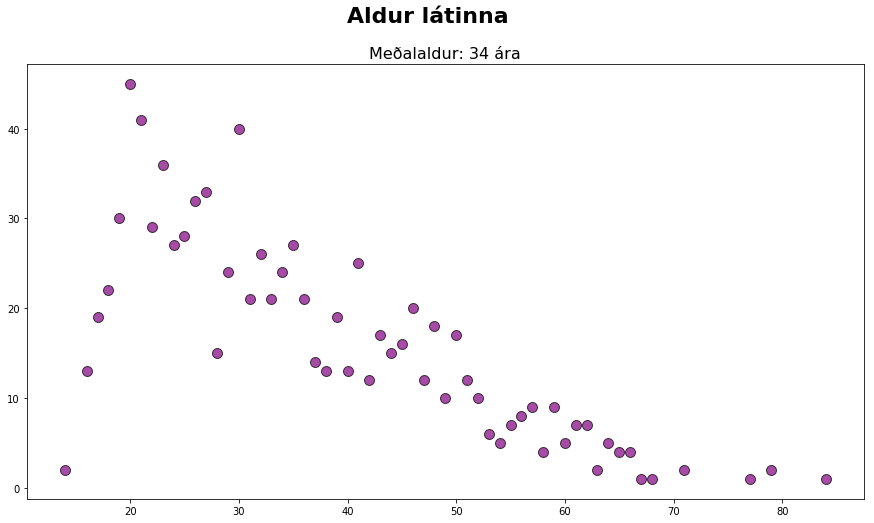

In [9]:
# Counting age and plotting as scatter plot
age_count = df['Aldur'].value_counts()
y = age_count.values
x = age_count.index
plt.rc('figure', figsize=(15, 8))
plt.scatter(x, y, s=100, alpha=0.7, c='purple', edgecolor='k')
plt.title('Meðalaldur: ' + str("{0:.0f}".format(round(df['Aldur'].mean(),0)) ) + ' ára', fontdict={'size': 16})
plt.suptitle('Aldur látinna ', fontsize=22, fontweight='bold')
plt.show()

### Hversu mörg skip hafa farist?

Ef við skoðum hversu mörg skip hafa farist við landið þar sem banaslys hefur orðið á fólki, þá má sjá að þau eru 169 talsins frá 1950. Hámarkið er í kringum 1960 þar sem 10 skip eða bátar fórust við landið. Árið 2001 fórust 3 skip en síðan þá hefur aldrei farist meira en eitt á ári og oft ekkert.

In [10]:
# Make a copy of the previous dataframe
shipDf =  df.copy()

# Only want to keep the values where a ship as been lost
shipDf = shipDf[shipDf['Flokkun atviks'] == 'Fórst með skipi']

# Drop unnecessary columns
shipDf = shipDf.drop(['Nafn', 'Aldur', 'Kyn', 'Flokkun atviks'], axis=1)

# Only want to keep the information about the ships and the count of dead
countList = shipDf.groupby(['Dagsetning', 'Skip']).size()
shipDf = shipDf.groupby(['Dagsetning', 'Skip']).first()
shipDf['Fjöldi látinna'] = countList

shipDf = shipDf.reset_index(drop=False)
shipDf = shipDf.set_index('Dagsetning')
shipDf.head()

,Skip,Tegund,Undirflokkur,Brl,Lgd,Smíðaár,Efni,Fjöldi látinna
Dagsetning,,,,,,,,
1950-01-07,Helgi VE,Fiskiskip,NaN,NaN,25.78,1939,Eik,10
1950-01-28,Vörður,Fiskiskip,Togari,625.00,57.15,1936,Stál,5
1950-03-04,Jón Magnússon,Fiskiskip,NaN,5.95,20.72,1946,Eik,6
1950-11-30,Trilla,Fiskiskip,NaN,NaN,NaN,NaN,NaN,2
1950-12-07,Trilla,Fiskiskip,NaN,NaN,NaN,NaN,NaN,3


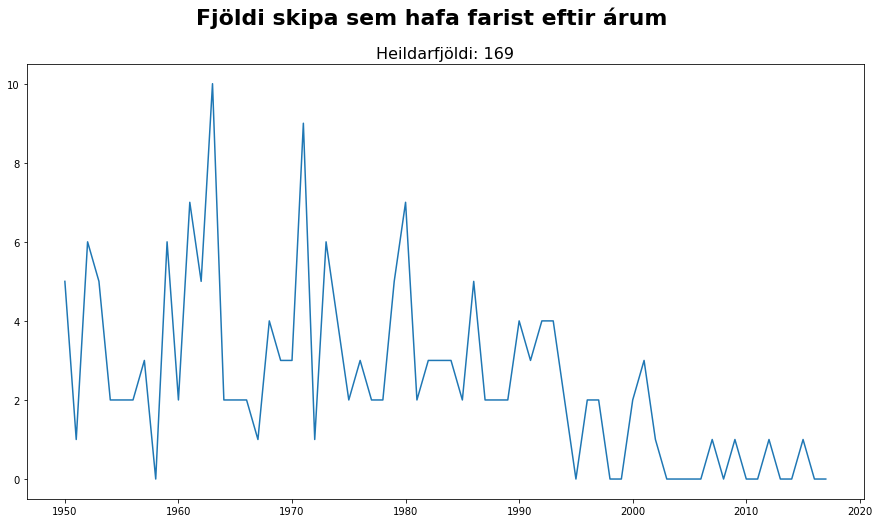

In [11]:
shipsByYear = shipDf.groupby(shipDf.index.year)

shipsByYearX = []
shipsByYearY = []

# This for loop is to make sure we also plot the few years where no one did die
for i in range(1950, 2018):
    shipsByYearX.append(i)
    if i in shipsByYear['Skip'].groups:
        shipsByYearY.append(len(shipsByYear['Skip'].groups[i]))
    else:
        shipsByYearY.append(0)

# Plotting the graph
plt.rc('figure', figsize=(15, 8))
plt.plot(shipsByYearX, shipsByYearY)
plt.title('Heildarfjöldi: ' + str(len(shipDf.index)), fontdict={'size': 16})
plt.suptitle('Fjöldi skipa sem hafa farist eftir árum', fontsize=22, fontweight='bold')
plt.show()

### Hversu gömul eru skipin þegar þau farast?

Þegar skoðaður er aldur skipa þegar þau farast má sjá að ekki virðist vera mikil fylgni milli þess að skip séu gömul og séu að farast þess vegna. Þó ert vert að taka það fram að í gögnunum eru engar upplýsingar um skip á sjó sem fórust ekki og líklegt er að fylgni sé milli aldurs þeirra skipa sem farast og aldurs skipa í sjó yfir höfuð. Ekki öll skip á gögnunum hafa upplýsingar um hvenær þau eru smíðuð svo í þessu tilfelli vinnum við bara með þau gögn sem við höfum. 

Text(0.5,1,'Aldur skipa \n')

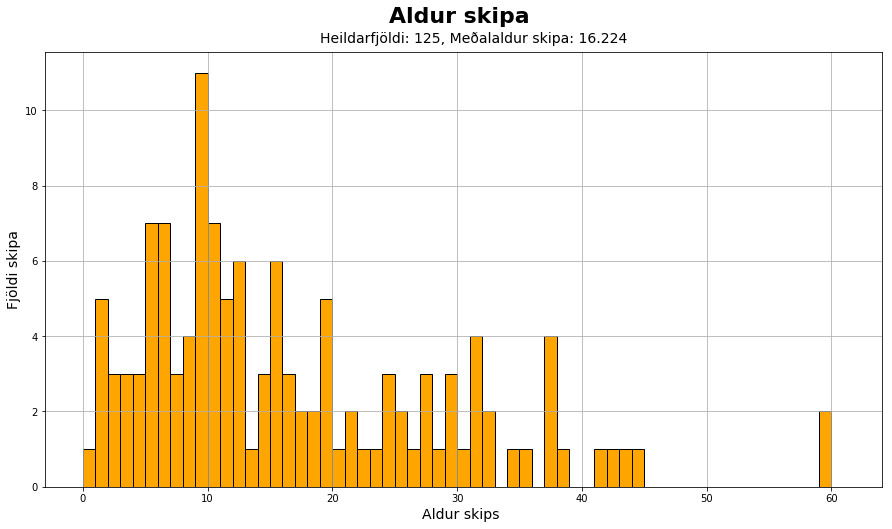

In [12]:
ship_age = pd.to_numeric(shipDf['Smíðaár'], errors='coerce').dropna()

# Calculate the ship age
for date, val in ship_age.iteritems():
    ship_age[date] = date.year - val


# Plotting and customizing the graph 
bin_range = np.arange(0, 62, 1)
ship_age_plot = ship_age.plot.hist(grid=True, alpha=1, color='orange', histtype='bar', ec='black', bins=bin_range)
ship_age_plot.set_xlabel('Aldur skips ', fontsize=14)
ship_age_plot.set_ylabel('Fjöldi skipa', fontsize=14)
ship_age_plot.text(19, 11.8, 'Heildarfjöldi: ' + str(ship_age.count()) + ', Meðalaldur skipa: ' + str(ship_age.mean()), fontsize=14)
ship_age_plot.set_title('Aldur skipa \n', fontdict={'size': 22, 'weight':'bold'})

### Tegundir skipa

Þegar tegundir skipanna eru skoðaðar má sjá að langflest skipanna hafa verið fiskiskip sem kemur svo sem ekki mikið á óvart og endurspeglar líklega þau skip sem hafa verið á sjó í hvert skipti. 

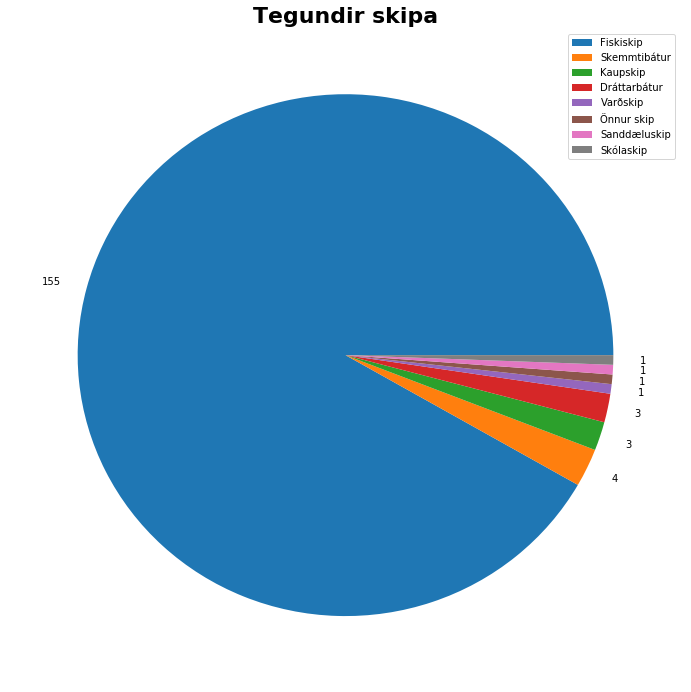

In [13]:
ship_type_count = shipDf['Tegund'].value_counts()
ship_type_keys = ship_type_count.keys()
ship_type_values = ship_type_count.values
plt.rc('figure', figsize=(12, 12))
plt.pie(ship_type_values, labels=ship_type_values)
plt.title('Tegundir skipa', fontsize=22, fontweight='bold')
plt.legend(ship_type_keys,loc=1)
plt.show()

Ef stærð skipa er skoðuð út frá lengd og þyngd kemur í ljós að í flestum tilfellum eru það minni bátar undir 20 metrum að lengd sem farast, þó svo að stærri skip hafi farist í einhverjum tilfellum. Stærsta skip sem hefur farist og leitt til banaslys var fragtskipið Dísarfell í eigu samskipa sem fórst árið 1997, en þar fórust 2 menn en aðrir björguðust.

![Dísarfell](./disarfell.jpg)

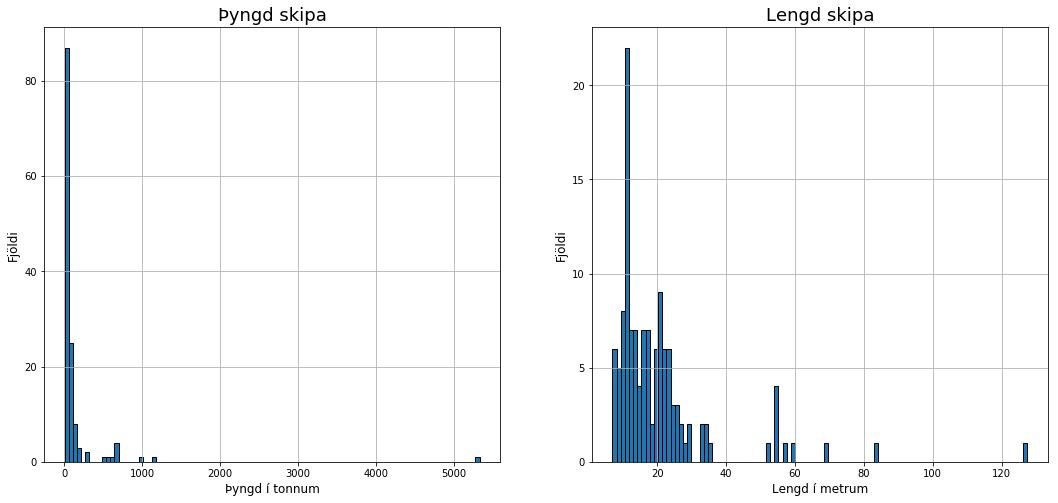

In [14]:
fig, axes = plt.subplots(1, 2)
plot1 = shipDf['Brl'].hist(bins=100, ax=axes[0], figsize=(18,8), histtype='bar', ec='black')
plot1.set_title('Þyngd skipa', fontsize=18)
plot1.set_xlabel('Þyngd í tonnum', fontsize=12)
plot1.set_ylabel('Fjöldi', fontsize=12)

plot2 = shipDf['Lgd'].hist(bins=100, ax=axes[1],histtype='bar', ec='black')
plot2.set_title('Lengd skipa', fontsize=18)
plot2.set_xlabel('Lengd í metrum', fontsize=12)
plot2.set_ylabel('Fjöldi', fontsize=12)
plot2

### Úr hverju er skipin smíðuð?

Ef við skoðum úr hvaða efni skipin sem hafa farist eru smíðuð og skiptum því niður á 10 ára tímabil má sjá út ýmsa hluti. Til að mynda er einna mest áberandi hvernig skipaflotinn hefur breyst úr því að vera smíðaður úr við, þá helst eik eða blandaðri eik, yfir í stál báta. Það sést greinilega að trébátar hafi farist oftar við Ísland og hægt að velta því fyrir sér hvort betri smíði báta sé ekki einn af stærri þáttum í bættu öryggi sjómanna. Einnig má sjá að enginn trefjaplastbátur virðist hafa farist fyrr en á tímabilinu 1990 - 2000 en þar er helsta ástæðan væntanlega sú að smíði þeirra hafi ekki byrjað fyrr en uppúr 1980 en þeir skipa stóran hluta flotans í dag, þá sérstaklega smábátaflotans. 


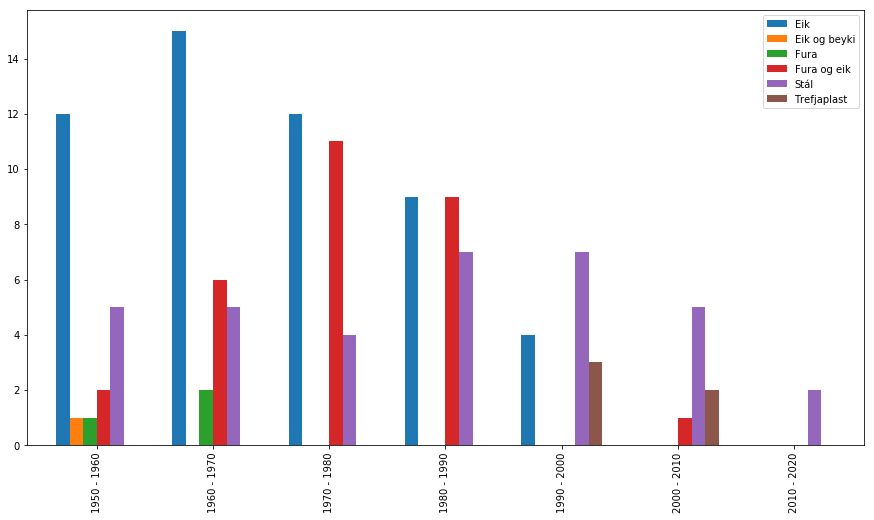

In [15]:
# This code is used to do this 10 years at a time
valueCountList = []

for i in range(1950, 2020, 10):
    valueCountList.append(shipDf[(shipDf.index.year >= i) & (shipDf.index.year < i+10)]['Efni'].value_counts())

yearLables = [] 
year = 1950

for years in deathByTenYear:
    yearLables.append(str(year) + ' - ' + str(year + 10))
    year += 10

pd.DataFrame(valueCountList, index=yearLables).plot.bar(width=0.7, figsize=(15,8))

### Hvaðan koma þau skip sem hafa farist?

Í gögnunum eru ekki að finna miklar upplýsingar um hvaðan skipin koma sem hafa farist eða hvar þau hafa farist. En fyrir mörg þeirra höfum við þó í nafninu ákveðnar upplýsingar í einkennisstöfum sem vísa til þeirrar sýslu sem þau koma úr. Sem dæmi má nefna _Haförn SH_ sem fórst árið 1983 en í þessu nafni sjáum við _SH_ sem vísar til _Snæfellsness- og Hnappadalssýsla_. Þetta getum við nýtt okkur til að mynda okkur hugmynd um hvaðan þau koma, þó svo að þau geti hafa verið hvar sem er við landið þegar þau fórust.

In [16]:
area_id_df = pd.read_csv('./csv\'s/letterAndArea.csv', header=None, index_col=0, names=['id', 'area'])
area_id_df['area'] = area_id_df['area'].str.strip()
shipAreaList = []

for ship in shipDf['Skip']:
    m = re.search('[A-Z][A-Z]$', ship)
    if m and m.group(0) in area_id_df.index:
        shipAreaList.append(area_id_df.loc[m.group(0)].item())
    else:
        shipAreaList.append('Nan')

shipDf['Sýsla'] = shipAreaList
shipDf.head()

,Skip,Tegund,Undirflokkur,Brl,Lgd,Smíðaár,Efni,Fjöldi látinna,Sýsla
Dagsetning,,,,,,,,,
1950-01-07,Helgi VE,Fiskiskip,NaN,NaN,25.78,1939,Eik,10,Vestmannaeyjar
1950-01-28,Vörður,Fiskiskip,Togari,625.00,57.15,1936,Stál,5,Nan
1950-03-04,Jón Magnússon,Fiskiskip,NaN,5.95,20.72,1946,Eik,6,Nan
1950-11-30,Trilla,Fiskiskip,NaN,NaN,NaN,NaN,NaN,2,Nan
1950-12-07,Trilla,Fiskiskip,NaN,NaN,NaN,NaN,NaN,3,Nan


Nú þurfum við að finna upplýsingar um staðsetningu þeirra sýsla sem koma fram í gögnunum og þá má hér að neðan sjá python kóða sem sækir upplýsingar um allar sýslur og kaupstaði á Íslandi frá wikipedia og síðan notum við þau hnit til að teikna inn á kortið að neðan.

In [17]:
# Base site
request = r.get('https://en.wikipedia.org/wiki/Counties_of_Iceland')

# Finding links to all counties and towns
soup = BeautifulSoup(request.content, "html.parser")
counties = soup.find(text='The historical counties were:').findNext('ul')
towns = counties.findNext('ul')
counties = counties.findAll('a')
towns = towns.findAll('a')

positions = {}

for a in counties:
    # Open all the countie links
    request = r.get('http://en.wikipedia.org' + urllib.parse.unquote(a['href']))
    en_soup = BeautifulSoup(request.content, "html.parser")
    # Finding the title
    title = en_soup.find('h1').text
    # Find another link where the coordinates are stored as decimals
    geo_href = en_soup.find('span', {'class': 'geo-default'}).parent['href']
    request = r.get('http:' + urllib.parse.unquote(geo_href))
    geo_soup = BeautifulSoup(request.content, "html.parser")
    # Assign the longitude and latitude to our positions dictionary
    latitude = float(geo_soup.find('span', {'class':'latitude'}).text)
    longitude = float(geo_soup.find('span', {'class':'longitude'}).text)
    positions[title] = [latitude, longitude]
    
    
# Similar to the code above but a little work around because 
# not all towns on the site include coordiante information
for a in towns:
    request = r.get('http://en.wikipedia.org' + urllib.parse.unquote(a['href']))
    soup = BeautifulSoup(request.content, "html.parser")
    geo_href = soup.find('span', {'class': 'geo-default'})
    if geo_href:
        title = soup.find('h1').text
        request = r.get('http:' + urllib.parse.unquote(geo_href.parent['href']))
        geo_soup = BeautifulSoup(request.content, "html.parser")
        latitude = float(geo_soup.find('span', {'class':'latitude'}).text)
        longitude = float(geo_soup.find('span', {'class':'longitude'}).text)
        positions[title] = [latitude, longitude]

Hérna teiknum við síðan kort af Íslandi og inn á það hnit þeirra sýsla sem við höfum upplýsingar um að bátar hafi farist frá.

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=242670.77780875342,292960.9378211689,778347.5118613883,720296.6393059522&bboxSR=3057&imageSR=3057&size=2000,1595&dpi=96&format=png32&f=image


/Users/Bensi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Bensi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/Bensi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Bensi/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


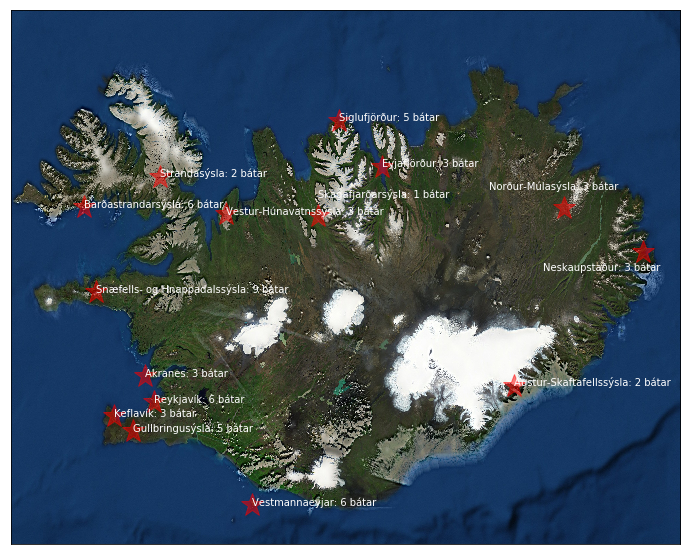

In [18]:
westlimit=-24.09
southlimit=63.05
eastlimit=-12.65
northlimit=66.85

# Draw the map with real image projection
basemap = Basemap(projection='mill',resolution='h', llcrnrlat=southlimit, urcrnrlat=northlimit, llcrnrlon=westlimit, urcrnrlon=eastlimit, epsg=3057)
basemap.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= True)

area_count = shipDf['Sýsla'].value_counts()


# Printing coordinates, labels and ship count to the screen
# We also a few if statement to change positions of few ill-fitting labels
for key in area_count.index.tolist():
    if key == 'Nan':
        continue
    val = area_count[key]
    x,y = basemap(positions[key][1], positions[key][0])
    basemap.plot(x, y, color='red', marker='*', markersize=24, alpha=0.5)
    if key == 'Neskaupstaður':
        plt.text(x - 80000, y - 15000, (str(key) + ': ' + str(val) + ' bátar'), color='white')
    elif key == 'Skagafjarðarsýsla':
        plt.text(x, y + 15000, (str(key) + ': ' + str(val) + ' bátar'), color='white')
    elif key == 'Norður-Múlasýsla':
        plt.text(x - 60000, y + 15000, (str(key) + ': ' + str(val) + ' bátar'), color='white')
    else:
        plt.text(x, y, (str(key) + ': ' + str(val) + ' bátar'), color='white')
plt.show()

Ef við skoðum kortið hér að ofan má sjá að dreifing þeirra báta sem hafa farist er nokkuð jöfn um landið. Þó má sjá að mest af bátum viðist hafa farið við vesturströnd landsins eða frá Vestmanneyjum og upp að Barðarstrandarsýslu og mest í Snæfells- og Hnappadalssýslu. Líklegasta ástæða fyrir þessari dreifingu er einfaldlega að á þessum stöðum hefur ávallt verið mest af bátum. Einnig má taka það fram að ekki eru upplýsingar í gögnunum um sýslu næstum allra skipanna og því eru þessar niðurstöður ekki full marktækar þó svo þær gefi hugmynd.  

### Fjöldi látinna með hverju skipi

Ef við skoðum hversu margir hafa látist í hverju slysi má sjá mikla fækkun og frá því í kringum 1990 hafa mest 3 látist í slysi þó svo að slysin hafi verið fleiri. Þetta má rekja til betri öryggis- og björgunarbúnaðar ásamt mikið öflugri viðbragðsaðila á borð við Landhelgisgæslu Íslands. 

![Landhelgisgæsla Íslands](http://www.lhg.is/media/frettir//mpopup/Thor-og-Lif.jpg)

Text(0.5,0,'Dagsetning slys')

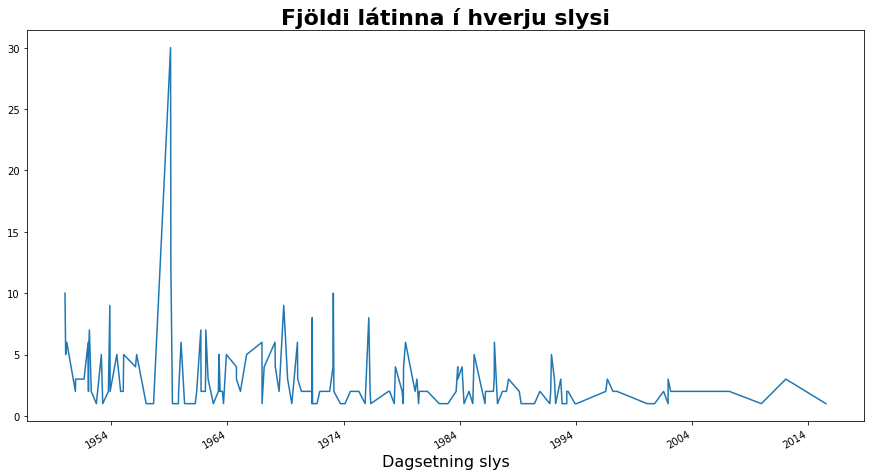

In [19]:
dead_count_plot = shipDf['Fjöldi látinna'].plot(figsize=(15, 8))
dead_count_plot.set_title('Fjöldi látinna í hverju slysi', fontsize=22, fontweight='bold' )
dead_count_plot.set_xlabel('Dagsetning slys', fontsize=16)

## Tenging milli veðurfars og slysa

Það liggur nokkuð augljóst fyrir að slæmt veðurfar eykur talsvert hættuna á slysum, þá sér í lagi mikill vindur sem veldur hárri ölduhæð, en einnig, skyggni eða samspil raka og hitastigs sem getur valdið ísingu á skipunum. Hér að neðan eru skoðuð tvö mismunandi gagnasett tengd veðri. Það fyrra eru veðurupplýsingar hvers dags fyrir sig frá árinu 1997 og er byggt á upplýsingum vefsíðunni [Weather underground](https://www.wunderground.com). Það seinna eru meðaltöl eftir mánuðum frá árinu 1949 og til dagsins í dag og er frá [Veðurstofu Íslands](http://www.vedur.is/).  
  
Þar sem við höfum ekki gögn yfir það hvar skipin hafa farist miðast allar upplýsingar við Reykjavík. Þó svo að veðurskilyrði virðist góð þá er auðvitað sá möguleiki fyrir hendi að allt önnur skilyrði hafi verið þar sem skipið fórst. 

![bræla](http://www.frettatiminn.is/wp-content/uploads/2018/03/skip-%C3%AD-ve%C3%B0ri.jpg)

In [20]:
# Reading in from multiple csv files
df_list = []
names = ['Dagsetning', 'Meðalhiti (°C)', 'Hámarkshiti (°C)', 'Lámarkshiti (°C)', 'Raki', 'Úrkoma (mm)', 'Loftþrýstingur (hPa)', 'Vindhraði (m/s)', 'Hámarskvindshraði (m/s)', 'Skyggni (km)']

for i in range(1997, 2018):
    year_frame = pd.read_csv('./csv\'s/' + str(i) + '.csv', index_col=0, header=None, names=names)
    df_list.append(year_frame)
    
weather_by_day_df = pd.concat(df_list)
weather_by_day_df.index =  pd.to_datetime(weather_by_day_df.index, format='%d/%m/%Y')

# Changeing km/h to m/s
weather_by_day_df['Vindhraði (m/s)'] = ((weather_by_day_df['Vindhraði (m/s)'] * 1000) / 3600).round(3)
weather_by_day_df['Hámarskvindshraði (m/s)'] = ((weather_by_day_df['Hámarskvindshraði (m/s)'] * 1000) / 3600).round(3)
weather_by_day_df.head()

,Meðalhiti (°C),Hámarkshiti (°C),Lámarkshiti (°C),Raki,Úrkoma (mm),Loftþrýstingur (hPa),Vindhraði (m/s),Hámarskvindshraði (m/s),Skyggni (km)
Dagsetning,,,,,,,,,
1997-01-01,3,4,2,93.0,0.0,1031.39,3.611,5.556,9.7
1997-01-02,4,4,3,98.0,0.0,1032.67,1.111,2.500,9.7
1997-01-03,2,3,2,90.0,0.0,1029.87,1.111,2.500,9.6
1997-01-04,2,3,0,86.0,0.0,1025.43,2.500,5.000,8.0
1997-01-05,-2,-1,-2,88.0,0.0,1024.70,1.389,3.056,9.9


In [21]:
names = ['Meðalhiti (°C)', 'Meðalhámarkshiti (°C)', 'Hæsti hiti (°C)', 'Meðallágmarkshiti (°C)', 'Lægsti hiti (°C)', 'Meðalrakastig', 'Heildar úrkoma', 'Meðalloftþrýstingur (hPa)', 'Meðalvindur (m/s)']
weather_by_month_df = pd.read_csv('./csv\'s/reykjavik_man_medal.csv')
weather_by_month_df['Mánuður/ár'] = pd.to_datetime(weather_by_month_df.ár*100+weather_by_month_df.mán, format='%Y%m')
weather_by_month_df.index = weather_by_month_df['Mánuður/ár']

# Dropping unnecessary columns 
weather_by_month_df = weather_by_month_df.drop(['stöð', 'ár', 'mán', 'txxD1', 'Mánuður/ár', 'tnnD1', 'rx', 'rxD1', 'n', 'sun'], axis=1)
weather_by_month_df.columns = names
weather_by_month_df.head()

,Meðalhiti (°C),Meðalhámarkshiti (°C),Hæsti hiti (°C),Meðallágmarkshiti (°C),Lægsti hiti (°C),Meðalrakastig,Heildar úrkoma,Meðalloftþrýstingur (hPa),Meðalvindur (m/s)
Mánuður/ár,,,,,,,,,
1949-01-01,-2.7,0.5,6.6,-6.8,-15.2,81.0,68.8,996.7,8.5
1949-02-01,0.0,2.5,7.8,-2.5,-7.5,87.0,80.0,989.0,9.2
1949-03-01,0.1,2.8,7.4,-2.9,-14.3,86.0,58.7,1010.4,5.9
1949-04-01,-0.0,3.1,6.6,-2.9,-8.9,77.0,51.8,1000.2,7.4
1949-05-01,3.6,7.2,13.0,0.3,-5.0,70.0,27.9,1014.8,6.9


### Hversu mikill vindur er þegar skip farst?

Ef við skoðum hversu mikill vindur hefur verið þegar skip frá 1997 hafa farist má sjá að í mörgum tilfellum hefur hann verið talsvert yfir meðallagi en samt sem áður er þó nokkur skipti þar sem vindur virðist hafa verið undir meðallagi. En hafa ber í huga að ekki er um mörg skip að ræða og mælingar miðast eingöngu við Reykjavík.

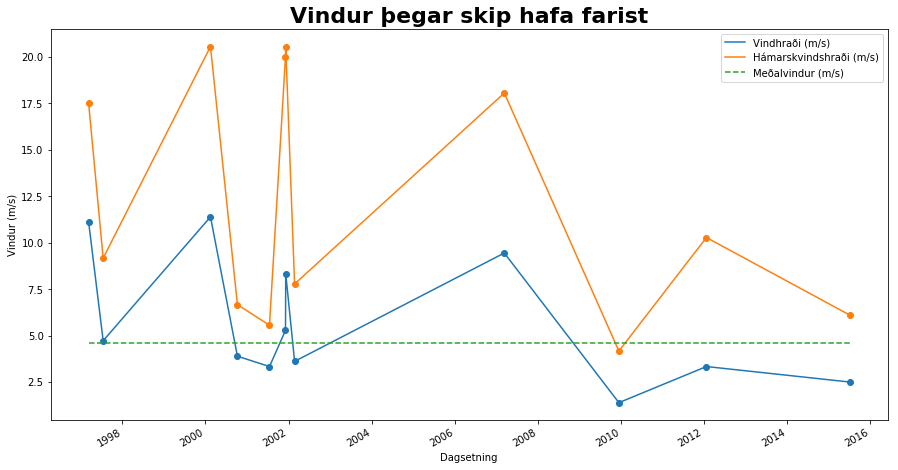

In [22]:
joined_data = shipDf.join(weather_by_day_df, how='inner')
y_mean = pd.Series([weather_by_day_df['Vindhraði (m/s)'].mean()]*len(joined_data), index=joined_data.index)
wind_plot = joined_data.plot(y='Vindhraði (m/s)', marker='o')
wind_plot = joined_data.plot(ax=wind_plot, y='Hámarskvindshraði (m/s)', marker='o')
wind_plot = y_mean.plot(ax=wind_plot, linestyle='--', legend=True, label='Meðalvindur (m/s)', figsize=(15,8))
wind_plot.set_ylabel('Vindur (m/s)')
wind_plot.set_title('Vindur þegar skip hafa farist', fontsize=22, fontweight='bold')
plt.show()

Ef skoðaðar eru veðurathuganir fyrir þá mánuði sem skip fórust í má sjá augljósa tengingu á milli vindasamra mánaða og skipa sem farast. Meðalmánuður þegar skip hefur farist er tæplega 7 m/s á meðan meðalmánuðurinn er í kringum 5,5 m/s. Þetta gildir sérstaklega um þau skip sem fórust fyrr.

Text(0.5,1,'Vindur í þeim mánuðum sem skip hafa farist')

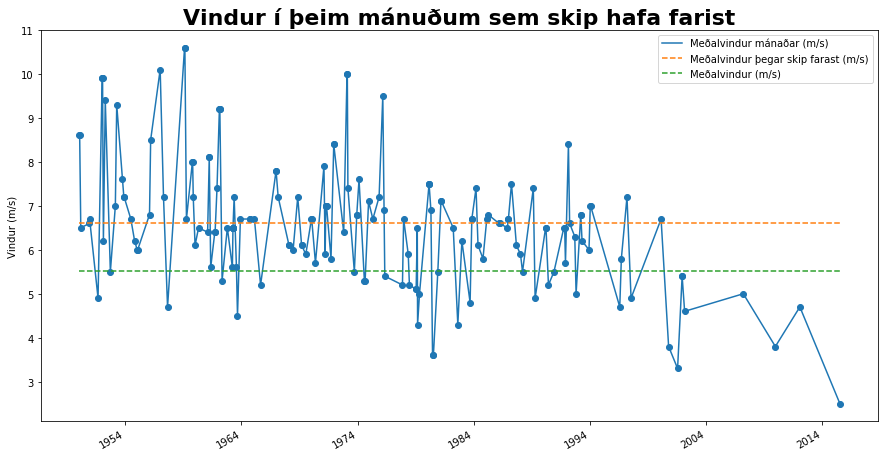

In [23]:
# Make a copy of dataframe to fill in values for each day of month
weather_by_month_copy = weather_by_month_df.copy()

# Get all dates from 1950 to 2018
dates = pd.date_range(shipDf.index[0], shipDf.index[-1], freq='D')
dates.name = 'Mánuður/ár'

# Fill the day values with same values for each day of the month
weather_by_month_copy = weather_by_month_copy.reindex(dates, method='ffill')

# Join and plot the wind data
joined_month = shipDf.join(weather_by_month_copy, how='inner')
y_mean = pd.Series([weather_by_month_df['Meðalvindur (m/s)'].mean()]*len(joined_month), index=joined_month.index)
y_mean_ship_down = pd.Series([joined_month['Meðalvindur (m/s)'].mean()]*len(joined_month), index=joined_month.index)
wind_plot = joined_month['Meðalvindur (m/s)'].plot(marker='o', legend=True, label='Meðalvindur mánaðar (m/s)')
wind_plot = y_mean_ship_down.plot(ax=wind_plot, linestyle='--', legend=True, label='Meðalvindur þegar skip farast (m/s)')
wind_plot = y_mean.plot(ax=wind_plot, linestyle='--', legend=True, label='Meðalvindur (m/s)', figsize=(15,8))
wind_plot.set_ylabel('Vindur (m/s)')
wind_plot.set_title('Vindur í þeim mánuðum sem skip hafa farist', fontsize=22, fontweight='bold')

Í þessu samhengi er áhugavert að skoða í hvaða mánuðum skip farast. Í þessari birtingu sjáum við augljóslega að langflest skipin farast á vetrarmánuðum sem kemur kannski ekki á óvart þar sem veður er verra þá mánuði og meiri hætta á ferð.

Text(0.5,1,'Skip sem hafa farist eftir mánuðum')

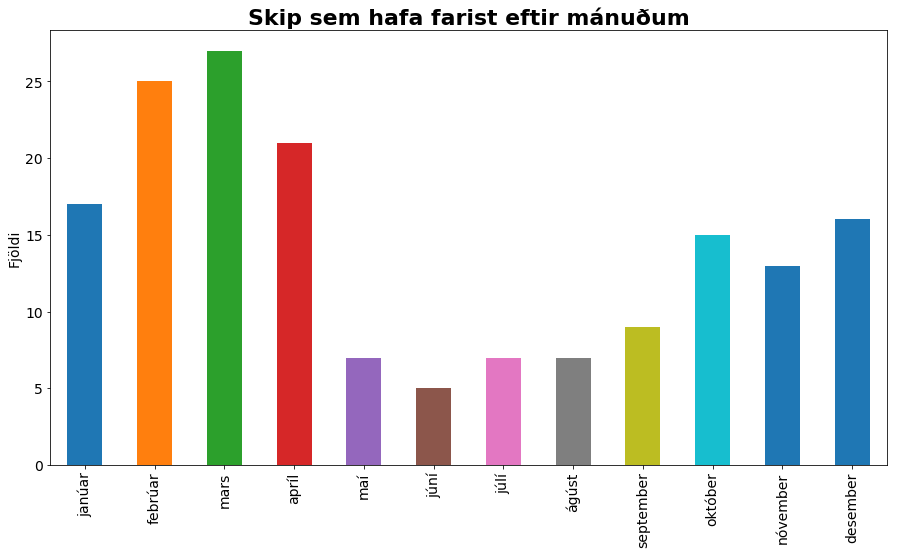

In [24]:
# Name the months
months = ['janúar', 'febrúar', 'mars', 'apríl', 'maí', 'júní','júlí', 'ágúst', 'september', 'október', 'nóvember','desember']

# Count lost ships by months and plot
count_by_month = shipDf.index.month.value_counts(sort=False)
count_by_month.index = months
month_plot = count_by_month.plot(kind='bar', figsize=(15,8), fontsize=14)
month_plot.set_ylabel('Fjöldi', fontsize=14)
month_plot.set_title('Skip sem hafa farist eftir mánuðum', fontsize=22, fontweight='bold')

### Hitastig

Ef við skoðum hitastig þeirra mánaða sem skipin hafa farist í má sjá að í fleiri tilfellum hefur mánuðurinn verið nokkuð kaldur þegar skip hefur farist sem passar við greiningu okkar að ofan þar sem skip farast frekar yfir vetrarmánuðina. Þó má sjá að í nokkuð mörgum tilfellum virðist meðalhiti mánaðarins ekki hafa mikið að gera með hvort skip ferst eða ekki.

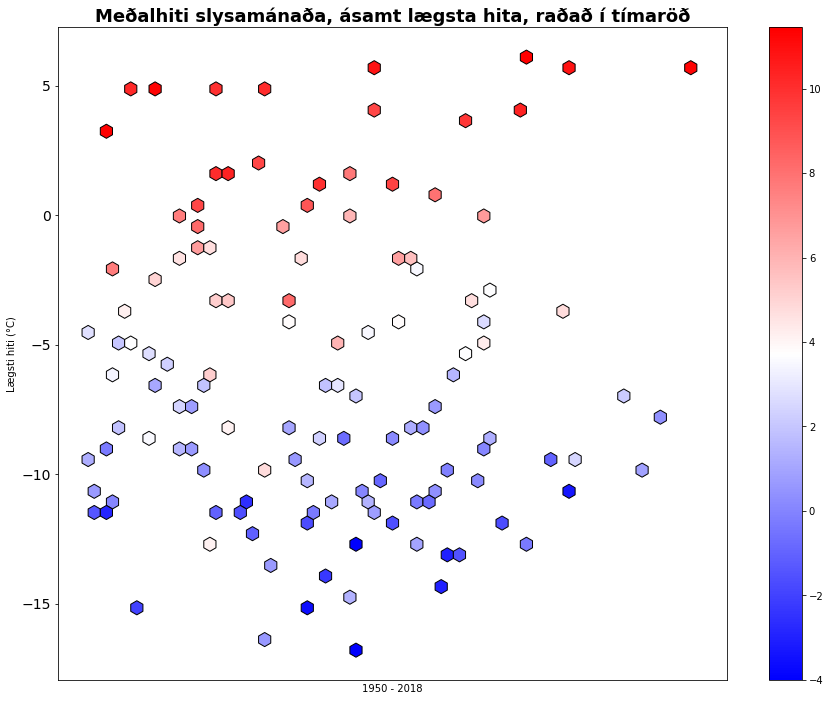

In [25]:
xtic = joined_month.index.year
joined_month['index'] = joined_month.index.astype(np.int64)
cmap = cm.get_cmap('bwr')
heat_plot = joined_month.plot.hexbin(x='index', y='Lægsti hiti (°C)', sharex=False, C='Meðalhiti (°C)', figsize=(15,12), cmap=cmap, gridsize=50, fontsize=14, edgecolor='k')
heat_plot.set_xticks([])
heat_plot.set_xlabel('1950 - 2018')
heat_plot.set_title('Meðalhiti slysamánaða, ásamt lægsta hita, raðað í tímaröð', fontsize=18, fontweight='bold')
heat_plot

### Spá fyrir um hvort skip farist eða maður falli fyrir borð

Að ætla að spá fyrir um hvort skip farist eða hverjar líkurnar séu að skip farist með þeim gögnum sem eru fyrir hendi verður aldrei mjög nákvæmt. Helsta ástæða þess er að eftir nákvæma skoðun á gögnunum sést að ekki eru mikið af upplýsingum fyrir hendi sem sýna nægilega mikla fylgni milli þeirra og þess að skip farist. En í fræðilegum tilgangi gerum við heiðarlega tilraun til að vinna með gögnin í þessu samhengi og reyna að spá fyrir um hvort skip farist eða maður falli fyrir borð í ákveðnum mánuði miðað við veðurupplýsingar.

In [26]:
# Make a copy of the previous dataframe
man_overboard =  df.copy()

# Only want to keep the values where a ship as been lost
man_overboard = man_overboard[man_overboard['Flokkun atviks'] == 'Féll fyrir borð']

# Drop unnecessary columns
man_overboard = man_overboard.drop(['Nafn', 'Aldur', 'Kyn', 'Flokkun atviks'], axis=1)

# Only want to keep the information about the ships and the count of dead
countList = man_overboard.groupby(['Dagsetning', 'Skip']).size()
man_overboard = man_overboard.groupby(['Dagsetning', 'Skip']).first()

man_overboard = man_overboard.reset_index(drop=False)
man_overboard = man_overboard.set_index('Dagsetning')
man_overboard

# Get the dataframes into 1
ship_man_down = pd.concat([shipDf, man_overboard])

# Extract the year and month from the dataframe
year_and_month = np.array((ship_man_down.index.year, ship_man_down.index.month)).T.tolist()

# Data made ready for the neural network 
weather_by_month_data =weather_by_month_df.copy()
weather_by_month_data['Slys'] = [1 if [i.year, i.month] in year_and_month else 0 for i in weather_by_month_data.index]
weather_by_month_data = weather_by_month_data[12:]
weather_by_month_data.head()



,Meðalhiti (°C),Meðalhámarkshiti (°C),Hæsti hiti (°C),Meðallágmarkshiti (°C),Lægsti hiti (°C),Meðalrakastig,Heildar úrkoma,Meðalloftþrýstingur (hPa),Meðalvindur (m/s),Slys
Mánuður/ár,,,,,,,,,,
1950-01-01,2.8,5.2,9.6,0.4,-4.3,84.0,128.3,996.0,8.6,1
1950-02-01,-0.7,2.4,6.1,-3.4,-13.6,80.0,30.6,992.4,6.6,0
1950-03-01,1.3,4.5,8.3,-1.2,-9.2,80.0,59.1,1005.6,6.5,1
1950-04-01,2.2,5.3,8.3,-0.5,-4.9,73.0,10.0,1003.3,6.3,0
1950-05-01,7.1,9.8,11.6,4.4,-0.3,76.0,61.2,1018.7,6.1,0


Hérna eru við komin með gögnin á form þar sem við höfum allar tölulegar upplýsingar um veður eftir mánuðum ásamt dálknum _'Slys'_ sem táknar hvort slys hafi orðið í tilteknum mánuði þar sem _1_ stendur fyrir að slys hafi orðið en _0_ ekki. Síðan eru 80% af gögnunum tekin af handahófi og notuð til að þjálfa upp tauganet(e. neural network). Þegar tauganetið er tilbúið eru hin 20% af gögnunum tekin prófað hvort spálíkanið spái rétt fyrir um hvort slys hafi orðið í ákveðnum mánuði. Á skífuritunum að neðan má sjá hversu vel spálíkanið spáir.

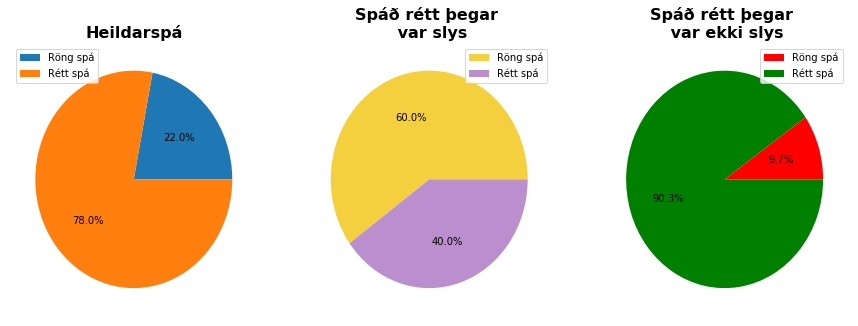

In [27]:
# X and Y to train and test the neural network
df_y = weather_by_month_data.iloc[:, 9:]
df_x = weather_by_month_data.iloc[:, 0:9]
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.20)

# Scale the network so diffrent varibles don't have completely differnet effect
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)
X_train

# Leyer size for the neural network chosen   and data classified
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 15), max_iter=1000)
mlp.fit(X_train, y_train.values.ravel())
predictions = mlp.predict(X_test)
predictions
y_test

# Data plotted
test_results = y_test.copy()
test_results['Spá'] = predictions

f, axarr = plt.subplots(1, 3, figsize=(15, 5))
result_plot = axarr[0]
result_acc_plot  = axarr[1]
result_not_acc_plot = axarr[2]

rigth_wrong = ['Röng spá', 'Rétt spá']

colors=[['#F4D03F', '#BB8FCE'], ['red', 'green']]

rigth_result = (test_results['Slys'] == test_results['Spá']).value_counts(sort=False)
result_plot.pie(rigth_result, autopct="%.1f%%")
result_plot.set_title('Heildarspá', fontsize=16, fontweight='bold')
result_plot.legend(rigth_wrong)

when_acc = test_results['Slys'] == 1
result_acc = (test_results[when_acc]['Spá']).value_counts()
result_acc_plot.pie(result_acc, autopct="%.1f%%", colors=colors[0])
result_acc_plot.set_title('Spáð rétt þegar \n var slys', fontsize=16, fontweight='bold')
result_acc_plot.legend(rigth_wrong)

when_not_acc = test_results['Slys'] == 0
result_not_acc = (test_results[when_not_acc]['Spá'] == 0).value_counts(sort=False)
result_not_acc_plot.pie(result_not_acc, autopct="%.1f%%", colors=colors[1])
result_not_acc_plot.set_title('Spáð rétt þegar \n var ekki slys', fontsize=16, fontweight='bold')
result_not_acc_plot.legend(rigth_wrong)

plt.show()

### Spá fyrir um efni skipa

Í þessum kafla munum við styðjast við ákvörðunartré (e. decision tree) til þess að spá fyrir um úr hvaða efni skip eru smíðuð við byrjum að koma gögnunum yfir á tölulegt form sem tréið getur notað.

In [28]:
# Data made ready for descion tree and ships that have nan in any column dropped
all_ships = df.copy()
all_ships = all_ships.groupby(['Dagsetning', 'Skip']).first()
all_ships = all_ships.reset_index()
all_ships = all_ships.drop(['Nafn', 'Aldur', 'Kyn', 'Flokkun atviks', 'Undirflokkur', 'Skip', 'Dagsetning'], axis=1)
all_ships = all_ships.dropna()
all_ships['Smíðaár'] = all_ships['Smíðaár'].astype(int)
all_ships['Efni'], material_index = pd.factorize(all_ships['Efni'])
all_ships['Tegund'], type_index = pd.factorize(all_ships['Tegund'])

all_ships.head()

,Tegund,Brl,Lgd,Smíðaár,Efni
1,0,625.00,57.15,1936,0
3,0,5.95,20.72,1946,1
6,0,656.00,54.00,1947,0
13,0,657.00,54.00,1947,0
14,1,775.00,61.63,1914,0


Hér að neðan er tréið þjálfað með hluta gagnanna og má sjá hér sjá mynd af fyrstu hæðum trésins og lesa út úr henni á hverju tréið er að skipta og hvernig það tekur ákvarðanir um hvar ákveðið skip ætti heima 

In [2]:
# Split to relevant attributes
x = all_ships.iloc[:, 0:4]
y = all_ships.iloc[:, 4:]

# Train the tree
clf = tree.DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)
clf.fit(X_train, y_train)

# Draw the decision tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=all_ships.columns.values[:-1],
                         class_names=material_index,
                         filled=True, rounded=True,
                         impurity=False,
                         special_characters=True, max_depth=3)  
graph = graphviz.Source(dot_data)
graph

NameError: name 'all_ships' is not defined

In [1]:
print(y_train)

NameError: name 'y_train' is not defined

Hér má síðan sjá samanburð úr prufu gögnunum og sjá með hversu mikilli nákvæmni tréið spáir fyrir um úr hverju skipið er smíðað.

Text(0.5,1,'Samanburður á spá og réttri niðurstöðu \n')

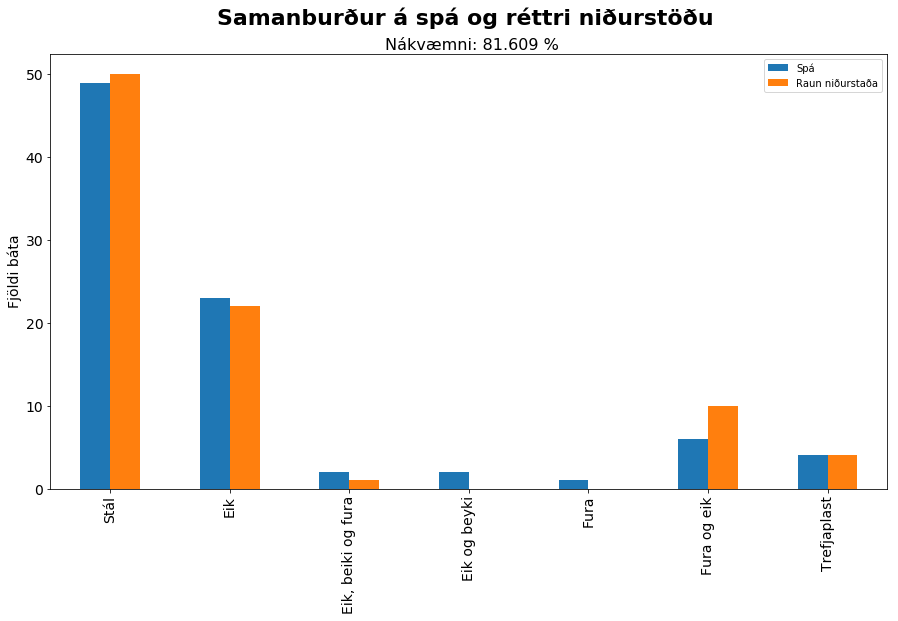

In [30]:
# Count how many predictions are for each varible
predict_dict = collections.Counter(clf.predict(X_test))
y_test_val = y_test['Efni'].value_counts()

# Assign the predictions and real values to lists for dataframe
predict_row = []
real_row = []
for i in range(0,7):
    if i in predict_dict:
        predict_row.append(predict_dict[i])
    else:
        predict_row.append(0)
    if i in y_test_val:
        real_row.append(y_test_val[i])
    else:
        real_row.append(0)
        

# The accuracy measured
percent_string = "{0:.3f}".format(accuracy_score(y_test, clf.predict(X_test))* 100)
        
# Plot the comparison
decision_tree = pd.DataFrame([predict_row, real_row], columns=material_index, index=['Spá', 'Raun niðurstaða'])
decision_tree_plot = decision_tree.T.plot(kind='bar', figsize=(15,8), fontsize=14)
decision_tree_plot.text(2.3, decision_tree.max().max() + 3, 'Nákvæmni: ' + percent_string + ' %', fontsize=16)
decision_tree_plot.set_ylabel('Fjöldi báta', fontsize=14)
decision_tree_plot.set_title('Samanburður á spá og réttri niðurstöðu \n', fontsize=22, fontweight='bold')

## Lokaorð

Ég lærði mikið af verkefninu bæði um hvernig  gott er að skoða og birta gögn en sérstaklega hvað er ótrúlega mikið af upplýsingum í gögnum þó svo að þær séu ekki endilega augljósar í fyrstu. Það er einnig virkilega áhugavert að reyna að setja gagnasett í samhengi við önnur gagnasett.  
  
Sjómennska hefur ávallt verið ein stærsta atvinnugrein Íslands og mikil og stór hluti af Íslandssögunni, ef t.d. er litið á hvernig byggðarlög á Íslandi hafa byggst upp má sjá að nánast allstaðar hefur verið byggt við sjó og höfn er í hverjum bæ. Í svo stórri en samt sem áður hættulegri atvinnugrein er augljóst að öryggi skiptir miklu máli og er mjög jávkætt að sjá augljóslega úr gögnunum mikla framþróun á því sviði.

![Bíldsey SH](http://brimbarinn.123.is/fs/f195b863-033b-4861-9c0c-ffc7442e2bac_M.jpg)